In [1]:
!pip install -U lightautoml
!pip install flaml[automl] matplotlib openml
!pip install -U ipywidgets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7

# Import các thư viện cần thiết

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from flaml import AutoML
import json

from flaml.automl.model import LGBMEstimator

import joblib

# Load data

In [3]:
calendar_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv')
inventory_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv')
train_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv')
test_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv')
df5 = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv')
weights_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv')

In [4]:
df5

,id,sales_hat
0,1226_2024-06-03,0
1,1226_2024-06-11,0
2,1226_2024-06-13,0
3,1226_2024-06-15,0
4,1226_2024-06-09,0
...,...,...
47016,4572_2024-06-03,0
47017,3735_2024-06-04,0
47018,3735_2024-06-03,0
47019,2129_2024-06-03,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   unique_id        int64  
 1   date             object 
 2   warehouse        object 
 3   total_orders     float64
 4   sales            float64
 5   sell_price_main  float64
 6   availability     float64
 7   type_0_discount  float64
 8   type_1_discount  float64
 9   type_2_discount  float64
 10  type_3_discount  float64
 11  type_4_discount  float64
 12  type_5_discount  float64
 13  type_6_discount  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 428.0+ MB


In [6]:
test_columns = list(test_df.columns)
keep_columns =  list(train_df.columns)
print(test_columns)
keep_columns 

['unique_id', 'date', 'warehouse', 'total_orders', 'sell_price_main', 'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount']


['unique_id',
 'date',
 'warehouse',
 'total_orders',
 'sales',
 'sell_price_main',
 'availability',
 'type_0_discount',
 'type_1_discount',
 'type_2_discount',
 'type_3_discount',
 'type_4_discount',
 'type_5_discount',
 'type_6_discount']

# EDA

# Data preprocessing

Ta chuẩn hóa cột `sales` theo từng `unique_id` và lưu scaler

In [7]:
scalers = {}
for unique_id in tqdm(train_df["unique_id"].unique()):
    scaler = StandardScaler()
    sales = train_df.loc[train_df["unique_id"] == unique_id, "sales"].values.reshape(-1, 1)
    scaler.fit(sales)
    scalers[unique_id] = scaler
    train_df.loc[train_df["unique_id"] == unique_id, "sales"] = scaler.transform(sales).flatten()
    
# --- Lưu lại để phục vụ cho deploy --- 
joblib.dump(scalers, "scalers.pkl")

100%|██████████| 5390/5390 [01:55<00:00, 46.69it/s]


['scalers.pkl']

Hàm `inverse_norm`: Khôi phục giá trị `sales` gốc từ dữ liệu đã chuẩn hóa

In [8]:
def inverse_norm(df_, indexes, y_pred, scalers):
    df_ = df_.copy()  # Tạo bản sao để tránh thay đổi df_ gốc
    df_.loc[indexes, "prediction_norm"] = y_pred
    df_.loc[indexes, "y_pred"] = df_.groupby("unique_id")["prediction_norm"].transform(
        lambda x: scalers[x.name].inverse_transform(x.values.reshape(-1, 1)).flatten()
        if x.name in scalers else x.values  # Nếu unique_id không có scaler, giữ nguyên
    )
    return df_.loc[indexes, "y_pred"].values

Chuyển đổi cột 'date' từ dạng chuỗi (string) sang kiểu datetime của Pandas, giúp so sánh ngày, tính khoảng cách thời gian 

In [9]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])


####  Lọc dữ liệu theo từng kho và chỉ lấy từ ngày 01-01-2016 trở đi.

In [10]:
Frankfurt_1 = calendar_df.query('date >= "2016-01-01 00:00:00" and warehouse =="Frankfurt_1"')
Prague_2 = calendar_df.query('date >= "2016-01-01 00:00:00" and warehouse =="Prague_2"')
Brno_1 = calendar_df.query('date >= "2016-01-01 00:00:00" and warehouse =="Brno_1"')
Munich_1 = calendar_df.query('date >= "2016-01-01 00:00:00" and warehouse =="Munich_1"')
Prague_3 = calendar_df.query('date >= "2016-01-01 00:00:00" and warehouse =="Prague_3"')
Prague_1 = calendar_df.query('date >= "2016-01-01 00:00:00" and warehouse =="Prague_1"')
Budapest_1 = calendar_df.query('date >= "2016-01-01 00:00:00" and warehouse =="Budapest_1"')

#### Tạo ra một DataFrame lịch mở rộng (calendar_extended) chứa các đặc trưng thời gian (`long_weekend`, `weekday`, `week_of_month`, `quarter`, `is_weekend`)

In [11]:
def process_calendar(df):
    df = df.sort_values('date').reset_index(drop=True)

    # long_weekend 
    # Xác định các ngày thuộc kỳ nghỉ cuối tuần dài (khi shops_closed = 1 và ngày trước đó cũng đóng cửa
    df['long_weekend'] = (
        (df['shops_closed'] == 1) & (df['shops_closed'].shift(1) == 1)
    ).astype(int)

    # weekday 
    # Ngày trong tuần (0 = Thứ Hai, 6 = Chủ Nhật).
    df['weekday'] = df['date'].dt.weekday 

    # week of month 
    df['week_of_month'] = df['date'].apply(lambda x: (x.day - 1) // 7 + 1)

    # quarter
    df['quarter'] = df['date'].dt.quarter

    # is weekend
    df['is_weekend'] = df['date'].dt.weekday.isin([5, 6]).astype(int)

    return df


dfs = ['Frankfurt_1', 'Prague_2', 'Brno_1', 'Munich_1', 'Prague_3', 'Prague_1', 'Budapest_1']
# Áp dụng hàm xử lý cho từng DataFrame và gom lại thành danh sách
processed_dfs = [process_calendar(globals()[df]) for df in dfs]
# Gộp tất cả các DataFrame lại thành một bảng duy nhất
calendar_extended = pd.concat(processed_dfs).sort_values('date').reset_index(drop=True)



In ra số lượng giá trị NaN trong các cột của calendar_extended. Giúp phát hiện các vấn đề dữ liệu (chẳng hạn như thiếu thông tin ngày lễ hoặc đóng cửa cửa hàng) trước khi gộp vào dữ liệu chính.

In [12]:
print(calendar_extended.isna().sum())

date                          0
holiday_name              22086
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
warehouse                     0
long_weekend                  0
weekday                       0
week_of_month                 0
quarter                       0
is_weekend                    0
dtype: int64


Gộp `calendar_extented` vào dữ liệu chính (train_df, test_df) để hỗ trợ dự đoán doanh số.

Kết hợp dữ liệu các tập `calendar` và `inventory` vốn liên quan trực tiếp với tập train vào tập train để có thể dễ dàng xử lý về sau. 

In [13]:
train_calendar = train_df.merge(calendar_extended, on=['date', 'warehouse'], how='left')
train_inventory = train_calendar.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')
train_df = train_inventory.merge(weights_df, on=['unique_id'], how='left')

test_calendar = test_df.merge(calendar_extended, on=['date', 'warehouse'], how='left')
test_df = test_calendar.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')

#### In ra các giá trị null của tập train sau khi kết hợp dữ liệu.

In [14]:
#Tìm giá trị null
train_df.isnull().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                   52
sales                          52
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
long_weekend                    0
weekday                         0
week_of_month                   0
quarter                         0
is_weekend                      0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_na

#### Xử lý giá trị null có dạng số 

In [15]:

train_df['sales'] = train_df['sales'].fillna(0)
train_df['total_orders'] = train_df['total_orders'].fillna(0)
train_df['sell_price_main'] = train_df['sell_price_main'].interpolate()

In [16]:
train_df.isnull().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                    0
sales                           0
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
long_weekend                    0
weekday                         0
week_of_month                   0
quarter                         0
is_weekend                      0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_na

#### Số lượng holiday name bị NaN với những ngày không phải holiday.

In [17]:
print("Số lượng NaN trong holiday_name theo holiday:")
print(train_df.groupby('holiday')['holiday_name'].apply(lambda x: x.isna().sum()))

Số lượng NaN trong holiday_name theo holiday:
holiday
0    3821651
1      22468
Name: holiday_name, dtype: int64


#### In ra những ngày lễ bị thiếu tên (NaN)

In [18]:
try:
    if 'train_df' not in globals():
        raise NameError("train_df không được định nghĩa. Vui lòng đảm bảo train_df đã được tạo từ mã trước đó.")
    
    # Kiểm tra các cột cần thiết
    required_columns = ['date', 'warehouse', 'holiday', 'holiday_name']
    missing_columns = [col for col in required_columns if col not in train_df.columns]
    if missing_columns:
        raise ValueError(f"train_df thiếu các cột: {missing_columns}")

    # Lọc các ngày lễ thiếu tên (holiday == 1 và holiday_name là NaN)
    missing_holidays = train_df[(train_df['holiday'] == 1) & (train_df['holiday_name'].isna())][['date', 'warehouse']]

    # Kiểm tra nếu không có dữ liệu nào
    if missing_holidays.empty:
        print("Không tìm thấy ngày lễ nào thiếu tên (holiday == 1 và holiday_name là NaN).")
    else:
        # Nhóm theo warehouse và lấy danh sách các ngày duy nhất, sắp xếp theo ngày
        missing_by_warehouse = missing_holidays.groupby('warehouse').agg({
            'date': lambda x: sorted(x.dt.strftime('%Y-%m-%d').unique().tolist())
        }).reset_index()

        # Đổi tên cột cho rõ ràng
        missing_by_warehouse.columns = ['warehouse', 'missing_holiday_dates']

        # In kết quả
        print("Các ngày lễ thiếu tên theo từng kho (sắp xếp theo ngày):")
        for _, row in missing_by_warehouse.iterrows():
            warehouse = row['warehouse']
            dates = row['missing_holiday_dates']
            print(f"\nKho: {warehouse}")
            print(f"Số ngày lễ thiếu tên: {len(dates)}")
            print("Các ngày thiếu tên lễ:", ", ".join(dates) if dates else "Không có ngày lễ thiếu tên")

except NameError as e:
    print(f"Lỗi: {e}")
except ValueError as e:
    print(f"Lỗi: {e}")
except Exception as e:
    print(f"Lỗi không xác định: {e}")

Các ngày lễ thiếu tên theo từng kho (sắp xếp theo ngày):

Kho: Brno_1
Số ngày lễ thiếu tên: 8
Các ngày thiếu tên lễ: 2021-04-03, 2021-04-04, 2022-04-16, 2022-04-17, 2023-04-08, 2023-04-09, 2024-03-30, 2024-03-31

Kho: Budapest_1
Số ngày lễ thiếu tên: 7
Các ngày thiếu tên lễ: 2021-04-03, 2021-04-04, 2022-04-17, 2023-04-08, 2023-04-09, 2024-03-30, 2024-03-31

Kho: Frankfurt_1
Số ngày lễ thiếu tên: 6
Các ngày thiếu tên lễ: 2022-04-16, 2022-04-17, 2023-04-08, 2023-04-09, 2024-03-30, 2024-03-31

Kho: Munich_1
Số ngày lễ thiếu tên: 6
Các ngày thiếu tên lễ: 2022-04-16, 2022-04-17, 2023-04-08, 2023-04-09, 2024-03-30, 2024-03-31

Kho: Prague_1
Số ngày lễ thiếu tên: 8
Các ngày thiếu tên lễ: 2021-04-03, 2021-04-04, 2022-04-16, 2022-04-17, 2023-04-08, 2023-04-09, 2024-03-30, 2024-03-31

Kho: Prague_2
Số ngày lễ thiếu tên: 8
Các ngày thiếu tên lễ: 2021-04-03, 2021-04-04, 2022-04-16, 2022-04-17, 2023-04-08, 2023-04-09, 2024-03-30, 2024-03-31

Kho: Prague_3
Số ngày lễ thiếu tên: 8
Các ngày thiếu tên 

#### Fill những ngày bị thiếu tên, gán những ngày không phải là holiday là "No holiday", còn những ngày là holiday thì sẽ định nghĩa ngày lễ của từng nhà kho nằm trong từng khu vực, đất nước.


In [19]:
# Danh sách ngày lễ cập nhật từ artifact trước
brno_holiday = [
    (['04/04/2021', '04/17/2022', '04/09/2023', '03/31/2024'], 'Easter Day'),
    (['04/03/2021', '04/16/2022', '04/08/2023', '03/30/2024'], 'Holy Saturday'),
    (['05/12/2024', '05/10/2020', '05/09/2021', '05/08/2022', '05/14/2023'], "Mother's Day"),
]
prague_1_holidays = [
    (['04/04/2021', '04/17/2022', '04/09/2023', '03/31/2024'], 'Easter Day'),
    (['04/03/2021', '04/16/2022', '04/08/2023', '03/30/2024'], 'Holy Saturday'),
]
prague_2_holidays = [
    (['04/04/2021', '04/17/2022', '04/09/2023', '03/31/2024'], 'Easter Day'),
    (['04/03/2021', '04/16/2022', '04/08/2023', '03/30/2024'], 'Holy Saturday'),
]
prague_3_holidays = [
    (['04/04/2021', '04/17/2022', '04/09/2023', '03/31/2024'], 'Easter Day'),
    (['04/03/2021', '04/16/2022', '04/08/2023', '03/30/2024'], 'Holy Saturday'),
]
budapest_holidays = [
    (['04/04/2021', '04/17/2022', '04/09/2023', '03/31/2024'], 'Easter Day'),
    (['04/03/2021', '04/08/2023', '03/30/2024'], 'Holy Saturday'),
]
frank_holidays = [
    (['04/17/2022', '04/09/2023', '03/31/2024'], 'Easter Day'),
    (['04/16/2022', '04/08/2023', '03/30/2024'], 'Holy Saturday'),
    (['05/12/2024', '05/14/2023', '05/08/2022', '05/09/2021'], "Mother's Day"),
]
munich_holidays = [
    (['04/17/2022', '04/09/2023', '03/31/2024'], 'Easter Day'),
    (['04/16/2022', '04/08/2023', '03/30/2024'], 'Holy Saturday'),
]

# Hàm fill_loss_holidays
def fill_loss_holidays(df_fill, warehouses, holidays):
    df = df_fill.copy()
    for item in holidays:
        dates, holiday_name = item
        generated_dates = [datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d') for date in dates]
        for generated_date in generated_dates:
            df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday'] = 1
            df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday_name'] = holiday_name
    return df

try:
    if 'train_df' not in globals() or 'test_df' not in globals():
        raise NameError("train_df hoặc test_df không được định nghĩa. Vui lòng đảm bảo cả hai đã được tạo từ mã trước đó.")

    # Kiểm tra các cột cần thiết
    required_columns = ['date', 'warehouse', 'holiday', 'holiday_name']
    for df_name, df in [('train_df', train_df), ('test_df', test_df)]:
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"{df_name} thiếu các cột: {missing_columns}")

    # Kiểm tra NaN trong holiday_name trước khi xử lý
    print("Số lượng NaN trong holiday_name (train_df) trước khi xử lý:", train_df['holiday_name'].isna().sum())
    print("\nSố lượng NaN trong holiday_name theo holiday (train_df):")
    print(train_df.groupby('holiday')['holiday_name'].apply(lambda x: x.isna().sum()))

    # Điền ngày lễ vào train_df
    train_df = fill_loss_holidays(df_fill=train_df, warehouses=['Prague_1', 'Prague_2', 'Prague_3'], holidays=prague_1_holidays)
    train_df = fill_loss_holidays(df_fill=train_df, warehouses=['Brno_1'], holidays=brno_holiday)
    train_df = fill_loss_holidays(df_fill=train_df, warehouses=['Munich_1'], holidays=munich_holidays)
    train_df = fill_loss_holidays(df_fill=train_df, warehouses=['Frankfurt_1'], holidays=frank_holidays)
    train_df = fill_loss_holidays(df_fill=train_df, warehouses=['Budapest_1'], holidays=budapest_holidays)

    # Điền các NaN còn lại trong holiday_name bằng "No Holiday"
    train_df['holiday_name'] = train_df['holiday_name'].fillna("No Holiday")

    # Kiểm tra NaN sau khi xử lý
    print("\nSố lượng NaN trong holiday_name (train_df) sau khi xử lý:", train_df['holiday_name'].isna().sum())
    print("\nPhân bố giá trị trong holiday_name (train_df):")
    print(train_df['holiday_name'].value_counts())
    print("\nGiá trị holiday_name khi holiday == 1 (train_df):")
    print(train_df[train_df['holiday'] == 1]['holiday_name'].value_counts())

    # Xử lý test_df (tương tự)
    print("\nSố lượng NaN trong holiday_name (test_df) trước khi xử lý:", test_df['holiday_name'].isna().sum())
    test_df = fill_loss_holidays(df_fill=test_df, warehouses=['Prague_1', 'Prague_2', 'Prague_3'], holidays=prague_1_holidays)
    test_df = fill_loss_holidays(df_fill=test_df, warehouses=['Brno_1'], holidays=brno_holiday)
    test_df = fill_loss_holidays(df_fill=test_df, warehouses=['Munich_1'], holidays=munich_holidays)
    test_df = fill_loss_holidays(df_fill=test_df, warehouses=['Frankfurt_1'], holidays=frank_holidays)
    test_df = fill_loss_holidays(df_fill=test_df, warehouses=['Budapest_1'], holidays=budapest_holidays)

    # Điền NaN còn lại trong test_df
    test_df['holiday_name'] = test_df['holiday_name'].fillna("No Holiday")

    # Kiểm tra NaN sau khi xử lý
    print("\nSố lượng NaN trong holiday_name (test_df) sau khi xử lý:", test_df['holiday_name'].isna().sum())
    print("\nPhân bố giá trị trong holiday_name (test_df):")
    print(test_df['holiday_name'].value_counts())


except NameError as e:
    print(f"Lỗi: {e}")
except ValueError as e:
    print(f"Lỗi: {e}")
except Exception as e:
    print(f"Lỗi không xác định: {e}")

Số lượng NaN trong holiday_name (train_df) trước khi xử lý: 3844119

Số lượng NaN trong holiday_name theo holiday (train_df):
holiday
0    3821651
1      22468
Name: holiday_name, dtype: int64

Số lượng NaN trong holiday_name (train_df) sau khi xử lý: 0

Phân bố giá trị trong holiday_name (train_df):
holiday_name
No Holiday                                                     3819598
International womens day                                         11830
Good Friday                                                      11577
Labour Day                                                       11530
Holy Saturday                                                    11237
Easter Day                                                       11231
Easter Monday                                                    10991
Christmas Eve                                                    10928
2nd Christmas Day                                                10803
New Years Day                                 

#### Dùng IQR để xử lý outlier trong sales

In [20]:
Q1 = np.log1p(train_df["sales"]).quantile(0.25)
Q3 = np.log1p(train_df["sales"]).quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

train_df = train_df[(np.log1p(train_df["sales"]) >= lower) & (np.log1p(train_df["sales"]) <= upper)]

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


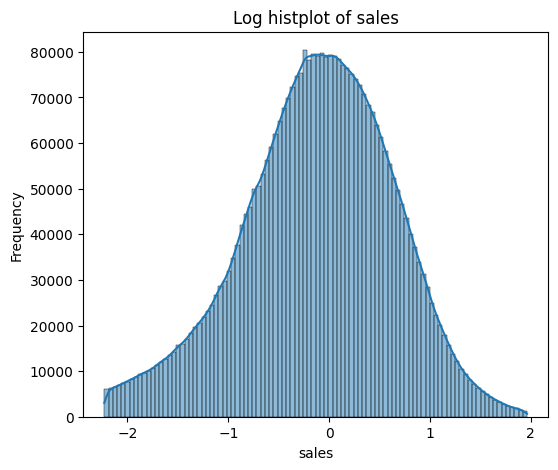

In [21]:
plt.figure(figsize=(6, 5))

sns.histplot(x=np.log1p(train_df['sales']), bins=100, kde=True)

plt.title(f'Log histplot of sales')
plt.xlabel('sales')
plt.ylabel('Frequency')

plt.show()

#### Xử lý các loại discount có giá trị âm

In [22]:
train_df.loc[train_df['type_0_discount'] < 0, 'type_0_discount'] = 0
train_df.loc[train_df['type_4_discount'] < 0, 'type_4_discount'] = 0
train_df.loc[train_df['type_6_discount'] < 0, 'type_6_discount'] = 0

In [23]:
train_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,week_of_month,quarter,is_weekend,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,weight
0,4845,2024-03-10,Budapest_1,6436.0,-0.506217,646.26,1.00,0.00000,0.0,0.0,...,2,1,1,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
1,4845,2021-05-25,Budapest_1,4663.0,-0.853596,455.96,1.00,0.00000,0.0,0.0,...,4,2,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
2,4845,2021-12-20,Budapest_1,6507.0,1.198840,455.96,1.00,0.00000,0.0,0.0,...,3,4,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
3,4845,2023-04-29,Budapest_1,5463.0,1.196031,646.26,0.96,0.20024,0.0,0.0,...,5,2,1,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596
4,4845,2022-04-01,Budapest_1,5997.0,1.327117,486.41,1.00,0.00000,0.0,0.0,...,1,2,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,1.925596


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514243 entries, 0 to 4007418
Data columns (total 31 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               object        
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   availability            float64       
 7   type_0_discount         float64       
 8   type_1_discount         float64       
 9   type_2_discount         float64       
 10  type_3_discount         float64       
 11  type_4_discount         float64       
 12  type_5_discount         float64       
 13  type_6_discount         float64       
 14  holiday_name            object        
 15  holiday                 int64         
 16  shops_closed            int64         
 17  winter_school_holidays  int64         
 18  school_

# Feature engineering

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47021 entries, 0 to 47020
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   unique_id               47021 non-null  int64         
 1   date                    47021 non-null  datetime64[ns]
 2   warehouse               47021 non-null  object        
 3   total_orders            47021 non-null  float64       
 4   sell_price_main         47021 non-null  float64       
 5   type_0_discount         47021 non-null  float64       
 6   type_1_discount         47021 non-null  float64       
 7   type_2_discount         47021 non-null  float64       
 8   type_3_discount         47021 non-null  float64       
 9   type_4_discount         47021 non-null  float64       
 10  type_5_discount         47021 non-null  float64       
 11  type_6_discount         47021 non-null  float64       
 12  holiday_name            47021 non-null  object

In [26]:
test_df['sales'] = 0.0

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47021 entries, 0 to 47020
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   unique_id               47021 non-null  int64         
 1   date                    47021 non-null  datetime64[ns]
 2   warehouse               47021 non-null  object        
 3   total_orders            47021 non-null  float64       
 4   sell_price_main         47021 non-null  float64       
 5   type_0_discount         47021 non-null  float64       
 6   type_1_discount         47021 non-null  float64       
 7   type_2_discount         47021 non-null  float64       
 8   type_3_discount         47021 non-null  float64       
 9   type_4_discount         47021 non-null  float64       
 10  type_5_discount         47021 non-null  float64       
 11  type_6_discount         47021 non-null  float64       
 12  holiday_name            47021 non-null  object

In [28]:
# 1. Tính category_sales cho train_df và map vào train_df
category_sales_train = train_df.groupby('L1_category_name_en')['sales'].agg(['mean']).reset_index()
category_sales_train.rename(columns={'mean': 'category_sales_avg'}, inplace=True)
train_df['category_sales_avg'] = train_df['L1_category_name_en'].map(
    category_sales_train.set_index('L1_category_name_en')['category_sales_avg']
)

# 2. Tính category_sales cho test_df và merge vào test_df
category_sales_test = test_df.groupby('L1_category_name_en')['sales'].agg(['mean']).reset_index()
category_sales_test.rename(columns={'mean': 'category_sales_avg'}, inplace=True)
test_df = test_df.merge(category_sales_test, on='L1_category_name_en', how='left')

# 3. Tính cat_order_stats cho train_df và map vào train_df
cat_order_stats_train = train_df.groupby('L1_category_name_en')['total_orders'].agg(['mean']).reset_index()
cat_order_stats_train.rename(columns={'mean': 'category_orders_avg'}, inplace=True)
train_df['category_orders_avg'] = train_df['L1_category_name_en'].map(
    cat_order_stats_train.set_index('L1_category_name_en')['category_orders_avg']
)

# 4. Tính cat_order_stats cho test_df và merge vào test_df
cat_order_stats_test = test_df.groupby('L1_category_name_en')['total_orders'].agg(['mean']).reset_index()
cat_order_stats_test.rename(columns={'mean': 'category_orders_avg'}, inplace=True)
test_df = test_df.merge(cat_order_stats_test, on='L1_category_name_en', how='left')

# Convert date to datetime and extract components
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear

# Xử lý NaN trong test_df (nếu cần)
test_df['category_sales_avg'].fillna(0.0, inplace=True)  # Vì sales trong test_df là 0
test_df['category_orders_avg'].fillna(test_df['total_orders'].mean(), inplace=True)

/tmp/ipykernel_13/2019617388.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['category_sales_avg'].fillna(0.0, inplace=True)  # Vì sales trong test_df là 0
/tmp/ipykernel_13/2019617388.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

#### Tạo đặc trưng max_discount trong các loại discount

In [29]:
discount_columns = [f'type_{i}_discount' for i in range(7)]
train_df['max_discount'] = train_df[discount_columns].max(axis=1)

discount_columns_test = [f'type_{i}_discount' for i in range(7)]
test_df['max_discount'] = test_df[discount_columns_test].max(axis=1)

In [30]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514243 entries, 0 to 4007418
Data columns (total 38 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               object        
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   availability            float64       
 7   type_0_discount         float64       
 8   type_1_discount         float64       
 9   type_2_discount         float64       
 10  type_3_discount         float64       
 11  type_4_discount         float64       
 12  type_5_discount         float64       
 13  type_6_discount         float64       
 14  holiday_name            object        
 15  holiday                 int64         
 16  shops_closed            int64         
 17  winter_school_holidays  int64         
 18  school_

#### Tạo thêm các đặc trưng về thời gian và holiday 

In [31]:
from sklearn.preprocessing import LabelEncoder
# Kiểm tra và chuyển cột date thành datetime
if 'date' not in train_df.columns:
    raise ValueError("Cột 'date' không tồn tại trong train_df")
if 'date' not in test_df.columns:
    raise ValueError("Cột 'date' không tồn tại trong test_df")

train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')
test_df['date'] = pd.to_datetime(test_df['date'], errors='coerce')

# Kiểm tra giá trị datetime hợp lệ
if train_df['date'].isna().all():
    raise ValueError("Cột 'date' trong train_df không chứa giá trị datetime hợp lệ")
if test_df['date'].isna().all():
    raise ValueError("Cột 'date' trong test_df không chứa giá trị datetime hợp lệ")

# Trích xuất các thành phần thời gian (dayofyear, day, month, year) từ cột date cho cả train_df và test_df
train_df['dayofyear'] = train_df['date'].dt.dayofyear
train_df["day"] = train_df["date"].dt.day
train_df["month"] = train_df["date"].dt.month
train_df["year"] = train_df["date"].dt.year

#### Tạo các đặc trưng `year_sin`, `year_cos`, `month_sin`, `month_cos`, `day_sin`, `day_cos` bằng cách áp dụng biến đổi sin và cos để biểu diễn tính chu kỳ của năm, tháng, và ngày. 

#### Các đặc trưng này giúp mô hình học được các mẫu lặp lại theo thời gian (ví dụ: doanh số tăng vào cuối năm hoặc vào các ngày cụ thể trong tháng).

#### Danh số cũng sẽ ảnh hưởng khi những kỳ nghỉ, lần đóng cửa tiếp theo của cửa hàng đến gần.

In [32]:
train_df['year_sin'] = np.sin(2 * np.pi * train_df['year'] / train_df['year'].max())
train_df['year_cos'] = np.cos(2 * np.pi * train_df['year'] / train_df['year'].max())
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)
train_df['day_sin'] = np.sin(2 * np.pi * train_df['day'] / 31)
train_df['day_cos'] = np.cos(2 * np.pi * train_df['day'] / 31)

 # 1. days_to_holiday (Tính số ngày đến kỳ nghỉ tiếp theo)
train_df['next_holiday_date'] = train_df.loc[train_df['holiday'] == 1, 'date'].shift(-1)
train_df['next_holiday_date'] = train_df['next_holiday_date'].bfill()
train_df['days_to_holiday'] = (train_df['next_holiday_date'] - train_df['date']).dt.days
train_df.drop(columns=['next_holiday_date'], inplace=True)

# 2. days_to_shops_closed: Số ngày đến ngày cửa hàng đóng cửa tiếp theo.
train_df['next_shops_closed_date'] = train_df.loc[train_df['shops_closed'] == 1, 'date'].shift(-1)
train_df['next_shops_closed_date'] =train_df['next_shops_closed_date'].bfill()
train_df['days_to_shops_closed'] = (train_df['next_shops_closed_date'] - train_df['date']).dt.days
train_df.drop(columns=['next_shops_closed_date'], inplace=True)

# 3. day_after_closing: Đánh dấu các ngày ngay sau khi cửa hàng đóng cửa.
train_df['day_after_closing'] = (
    (train_df['shops_closed'] == 0) & (train_df['shops_closed'].shift(1) == 1)
    ).astype(int)
train_df['long_weekend'] = (
        (train_df['shops_closed'] == 1) & (train_df['shops_closed'].shift(1) == 1)
    ).astype(int)

#### Biến đổi tương tự đối với tập test

In [33]:
test_df['dayofyear'] = test_df['date'].dt.dayofyear
test_df["day"] = test_df["date"].dt.day
test_df["month"] = test_df["date"].dt.month
test_df["year"] = test_df["date"].dt.year

test_df['year_sin'] = np.sin(2 * np.pi * test_df['year'] / test_df['year'].max())
test_df['year_cos'] = np.cos(2 * np.pi * test_df['year'] / test_df['year'].max())
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['day_sin'] = np.sin(2 * np.pi * test_df['day'] / 31)
test_df['day_cos'] = np.cos(2 * np.pi * test_df['day'] / 31)
                            
 # 1. days_to_holiday
test_df['next_holiday_date'] = test_df.loc[test_df['holiday'] == 1, 'date'].shift(-1)
test_df['next_holiday_date'] = test_df['next_holiday_date'].bfill()
test_df['days_to_holiday'] = (test_df['next_holiday_date'] - test_df['date']).dt.days
test_df.drop(columns=['next_holiday_date'], inplace=True)

# 2. days_to_shops_closed
test_df['next_shops_closed_date'] = test_df.loc[test_df['shops_closed'] == 1, 'date'].shift(-1)
test_df['next_shops_closed_date'] =test_df['next_shops_closed_date'].bfill()
test_df['days_to_shops_closed'] = (test_df['next_shops_closed_date'] - test_df['date']).dt.days
test_df.drop(columns=['next_shops_closed_date'], inplace=True)

# 3. day_after_closing
test_df['day_after_closing'] = (
    (test_df['shops_closed'] == 0) & (test_df['shops_closed'].shift(1) == 1)
    ).astype(int)

test_df['long_weekend'] = (
        (test_df['shops_closed'] == 1) & (test_df['shops_closed'].shift(1) == 1)
    ).astype(int)


#### Kiểm tra kết quả

In [34]:
print("Cột trong train_df sau khi thêm đặc trưng:", train_df.columns.tolist())
print("Cột trong test_df sau khi thêm đặc trưng:", test_df.columns.tolist())

Cột trong train_df sau khi thêm đặc trưng: ['unique_id', 'date', 'warehouse', 'total_orders', 'sales', 'sell_price_main', 'availability', 'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'long_weekend', 'weekday', 'week_of_month', 'quarter', 'is_weekend', 'product_unique_id', 'name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'weight', 'category_sales_avg', 'category_orders_avg', 'month', 'day_of_week', 'week_of_year', 'day_of_year', 'max_discount', 'dayofyear', 'day', 'year', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'days_to_holiday', 'days_to_shops_closed', 'day_after_closing']
Cột trong test_df sau khi thêm đặc trưng: ['unique_id', 'date', 'warehouse', 'total_orders', 'sell_price_main', 'type_0_discount', 'type_1_discount', 'type_2_dis

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514243 entries, 0 to 4007418
Data columns (total 50 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               object        
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   availability            float64       
 7   type_0_discount         float64       
 8   type_1_discount         float64       
 9   type_2_discount         float64       
 10  type_3_discount         float64       
 11  type_4_discount         float64       
 12  type_5_discount         float64       
 13  type_6_discount         float64       
 14  holiday_name            object        
 15  holiday                 int64         
 16  shops_closed            int64         
 17  winter_school_holidays  int64         
 18  school_

In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47021 entries, 0 to 47020
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   unique_id               47021 non-null  int64         
 1   date                    47021 non-null  datetime64[ns]
 2   warehouse               47021 non-null  object        
 3   total_orders            47021 non-null  float64       
 4   sell_price_main         47021 non-null  float64       
 5   type_0_discount         47021 non-null  float64       
 6   type_1_discount         47021 non-null  float64       
 7   type_2_discount         47021 non-null  float64       
 8   type_3_discount         47021 non-null  float64       
 9   type_4_discount         47021 non-null  float64       
 10  type_5_discount         47021 non-null  float64       
 11  type_6_discount         47021 non-null  float64       
 12  holiday_name            47021 non-null  object

#### Tạo thêm các đặc trưng về `sales`, cụ thể là xác định các khoảng thời gian lag (`lag_features` = [1, 7, 14, 28]), tương ứng với doanh số cách hiện tại 1 ngày, 7 ngày, 14 ngày, và 28 ngày.

In [37]:
lag_features = [1, 7, 14, 28]

In [38]:
# Đảm bảo cột date là datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Nhóm dữ liệu theo unique_id và warehouse
train_grouped = train_df.groupby(["unique_id", "warehouse"])

# Tính lag features cho train_df
for i in lag_features:
    # Tạo cột lag
    train_df[f"sales_item_warehouse_lag_{i}"] = train_grouped["sales"].shift(i)
    # Điền NaN bằng giá trị sales cuối cùng của nhóm, nếu không có thì điền 0
    train_df[f"sales_item_warehouse_lag_{i}"] = train_df[f"sales_item_warehouse_lag_{i}"].fillna(
        train_grouped["sales"].transform("last")
    ).fillna(0)

# Kiểm tra NaN trong các cột lag của train_df
print("\nKiểm tra NaN trong các cột lag của train_df:")
print(train_df[[f"sales_item_warehouse_lag_{i}" for i in lag_features]].isna().sum())

# Kiểm tra phân bố của các cột lag trong train_df
print("\nThống kê mô tả cho các cột lag trong train_df:")
print(train_df[[f"sales_item_warehouse_lag_{i}" for i in lag_features]].describe())


Kiểm tra NaN trong các cột lag của train_df:
sales_item_warehouse_lag_1     0
sales_item_warehouse_lag_7     0
sales_item_warehouse_lag_14    0
sales_item_warehouse_lag_28    0
dtype: int64

Thống kê mô tả cho các cột lag trong train_df:
       sales_item_warehouse_lag_1  sales_item_warehouse_lag_7  \
count                3.514243e+06                3.514243e+06   
mean                 1.550552e-01                1.549480e-01   
std                  8.776796e-01                8.775644e-01   
min                 -8.924791e-01               -8.924791e-01   
25%                 -4.452017e-01               -4.452357e-01   
50%                 -7.664302e-02               -7.673945e-02   
75%                  5.008300e-01                5.008230e-01   
max                  6.112597e+00                6.112597e+00   

       sales_item_warehouse_lag_14  sales_item_warehouse_lag_28  
count                 3.514243e+06                 3.514243e+06  
mean                  1.548032e-01         

#### Tương tự với tập test

In [39]:
test_df['date'] = pd.to_datetime(test_df['date'])

# Nhóm dữ liệu theo unique_id và warehouse
test_grouped = test_df.groupby(["unique_id", "warehouse"])

# Tính lag features cho test_df
for i in lag_features:
    # Tạo cột lag
    test_df[f"sales_item_warehouse_lag_{i}"] = test_grouped["sales"].shift(i)
    # Điền NaN bằng giá trị sales cuối cùng của nhóm, nếu không có thì điền 0
    test_df[f"sales_item_warehouse_lag_{i}"] = test_df[f"sales_item_warehouse_lag_{i}"].fillna(
        test_grouped["sales"].transform("last")
    ).fillna(0)

# Kiểm tra NaN trong các cột lag của test_df
print("\nKiểm tra NaN trong các cột lag của test_df:")
print(test_df[[f"sales_item_warehouse_lag_{i}" for i in lag_features]].isna().sum())

# Kiểm tra phân bố của các cột lag trong test_df
print("\nThống kê mô tả cho các cột lag trong test_df:")
print(test_df[[f"sales_item_warehouse_lag_{i}" for i in lag_features]].describe())


Kiểm tra NaN trong các cột lag của test_df:
sales_item_warehouse_lag_1     0
sales_item_warehouse_lag_7     0
sales_item_warehouse_lag_14    0
sales_item_warehouse_lag_28    0
dtype: int64

Thống kê mô tả cho các cột lag trong test_df:
       sales_item_warehouse_lag_1  sales_item_warehouse_lag_7  \
count                     47021.0                     47021.0   
mean                          0.0                         0.0   
std                           0.0                         0.0   
min                           0.0                         0.0   
25%                           0.0                         0.0   
50%                           0.0                         0.0   
75%                           0.0                         0.0   
max                           0.0                         0.0   

       sales_item_warehouse_lag_14  sales_item_warehouse_lag_28  
count                      47021.0                      47021.0  
mean                           0.0           

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514243 entries, 0 to 4007418
Data columns (total 54 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   unique_id                    int64         
 1   date                         datetime64[ns]
 2   warehouse                    object        
 3   total_orders                 float64       
 4   sales                        float64       
 5   sell_price_main              float64       
 6   availability                 float64       
 7   type_0_discount              float64       
 8   type_1_discount              float64       
 9   type_2_discount              float64       
 10  type_3_discount              float64       
 11  type_4_discount              float64       
 12  type_5_discount              float64       
 13  type_6_discount              float64       
 14  holiday_name                 object        
 15  holiday                      int64         
 16  shops

In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47021 entries, 0 to 47020
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   unique_id                    47021 non-null  int64         
 1   date                         47021 non-null  datetime64[ns]
 2   warehouse                    47021 non-null  object        
 3   total_orders                 47021 non-null  float64       
 4   sell_price_main              47021 non-null  float64       
 5   type_0_discount              47021 non-null  float64       
 6   type_1_discount              47021 non-null  float64       
 7   type_2_discount              47021 non-null  float64       
 8   type_3_discount              47021 non-null  float64       
 9   type_4_discount              47021 non-null  float64       
 10  type_5_discount              47021 non-null  float64       
 11  type_6_discount              47021 non-nu

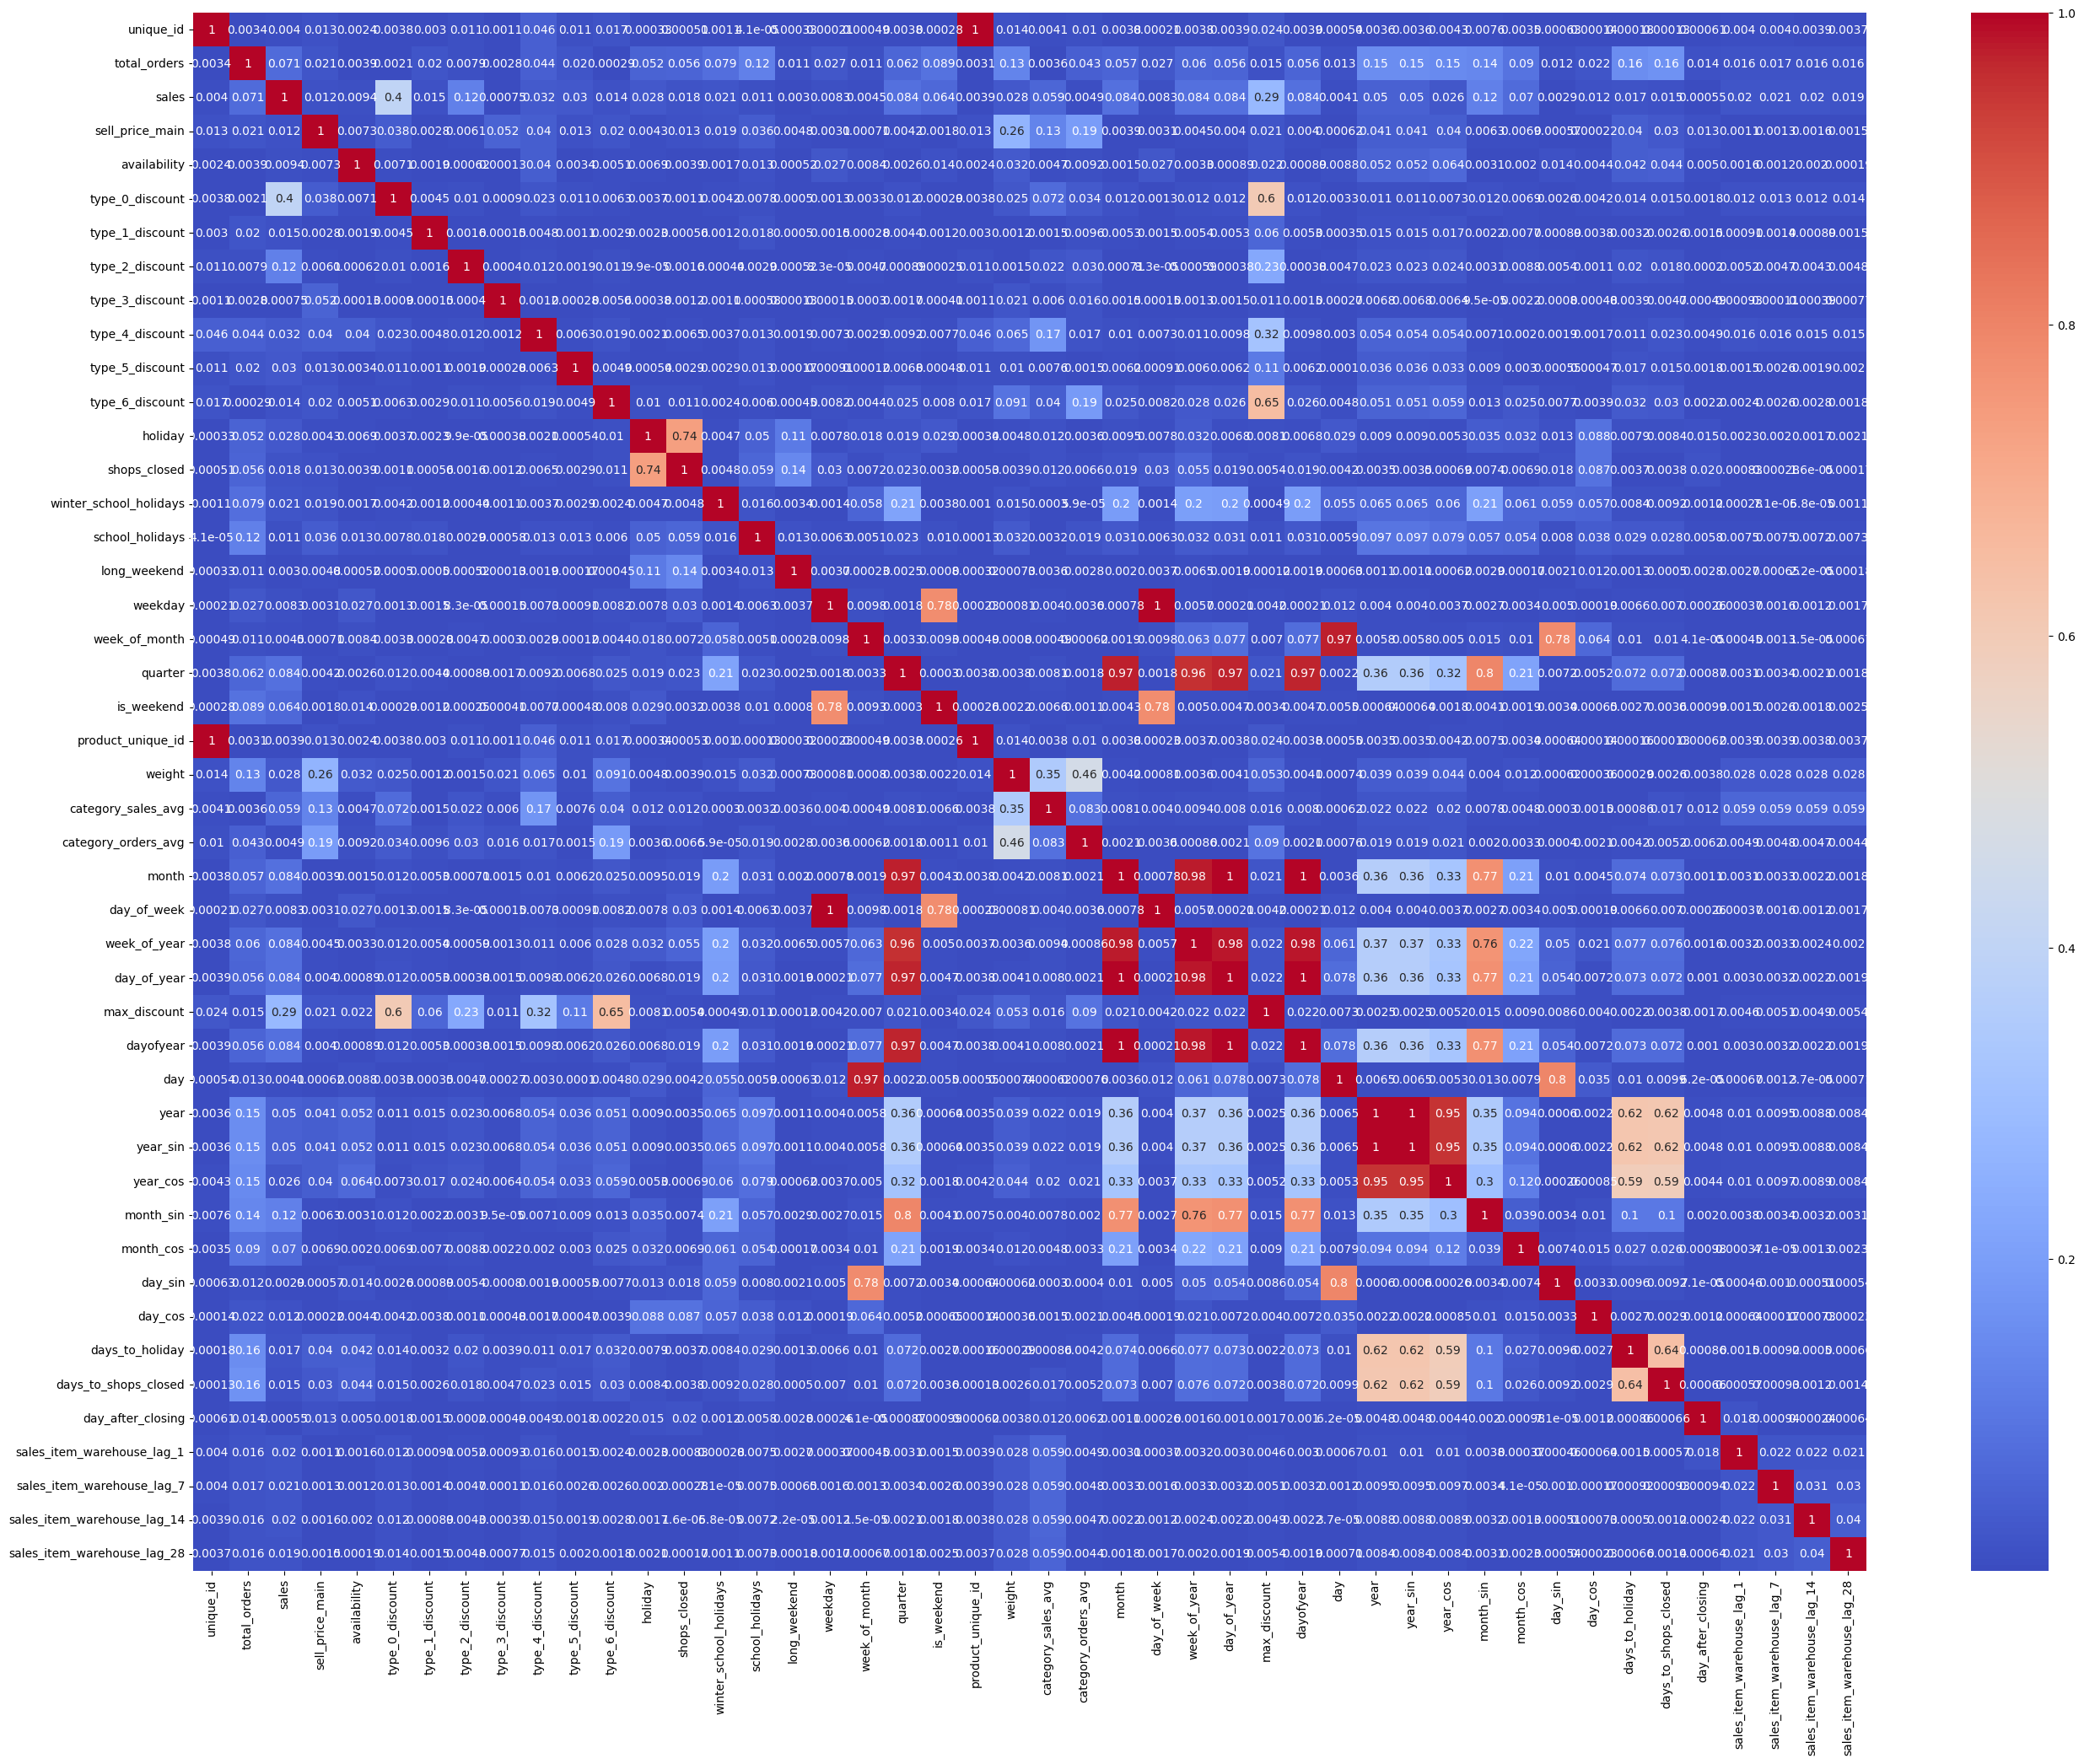

In [42]:
plt.figure(figsize=(32, 24))
corr_matrix = train_df.corr(numeric_only=True).abs()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Thực hiện loại bỏ weight và availability vì không cần thiết cho việc train, đồng thời giảm nhiễu, giảm chiều và giữ sự nhất quán của dữ liệu.

In [43]:
columns_to_drop = ['weight', 'availability']
train_df = train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], errors='ignore')

#### Tối ưu hóa kiểu dữ liệu: ta chuyển đổi các cột số thực (float64) thành float32, số nguyên (int64) thành int32, và cột boolean (bool) thành uint8 trong cả train_df và test_df để giảm bộ nhớ sử dụng

In [44]:
for col in train_df.select_dtypes('float64'):
    train_df[col] = train_df[col].astype('float32')
for col in train_df.select_dtypes('int64'):
    train_df[col] = train_df[col].astype('int32')
for col in train_df.select_dtypes('bool'):
    train_df[col] = train_df[col].astype('uint8')

for col in test_df.select_dtypes('float64'):
    test_df[col] = test_df[col].astype('float32')
for col in test_df.select_dtypes('int64'):
    test_df[col] = test_df[col].astype('int32')
for col in test_df.select_dtypes('bool'):
    test_df[col] = test_df[col].astype('uint8')

#### Label encoding các cột object thành số nguyên, giúp mô hình học máy xử lý được các giá trị chuỗi.

In [45]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['warehouse', 'holiday_name', 'name', 'L1_category_name_en', 
                    'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']

label_encoders = {}
for col in categorical_cols:
    if col in train_df.columns and col in test_df.columns:
        le = LabelEncoder()
        # Xử lý từng cột để giảm RAM
        train_vals = train_df[col].astype(str).values
        test_vals = test_df[col].astype(str).values
        combined = np.concatenate([train_vals, test_vals])
        le.fit(combined)
        train_df[col] = le.transform(train_vals)
        test_df[col] = le.transform(test_vals)
        label_encoders[col] = le
        del combined  # Xóa biến tạm
        
# --- Lưu lại để phục vụ cho deploy --- 
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

#### Loại bỏ cột datetime64 và chỉ giữ cột số.
#### Xác định các đặc trưng (features) bằng cách chọn các cột số từ train_df và test_df, loại bỏ các cột không liên quan (`unique_id`, `date`, `sales`, `availability`).

In [46]:
train_features = [c for c in train_df.columns if c not in ["unique_id", "date", "sales", "availability"] 
                 and train_df[c].dtype in [np.float32, np.int32, np.uint8, np.int64]]
test_features = [c for c in test_df.columns if c not in ["unique_id", "date", "sales", "availability"] 
                 and test_df[c].dtype in [np.float32, np.int32, np.uint8, np.int64]]

#### Lấy tập hợp chung để đảm bảo các đặc trưng giống nhau trong cả hai tập.

In [47]:
features = list(set(train_features) & set(test_features))

# Kiểm tra kiểu dữ liệu của features
print("Feature dtypes in train_df:")
for col in features:
    print(f"{col}: {train_df[col].dtype}")
print("\nFeature dtypes in test_df:")
for col in features:
    print(f"{col}: {test_df[col].dtype}")

# Xử lý NaN
train_df[features] = train_df[features].fillna(train_df[features].mean())
test_df[features] = test_df[features].fillna(train_df[features].mean())

Feature dtypes in train_df:
quarter: int32
month: int32
weekday: int32
year: int32
shops_closed: int32
day_of_year: int32
month_sin: float32
product_unique_id: int32
L3_category_name_en: int64
is_weekend: int32
L4_category_name_en: int64
day: int32
L1_category_name_en: int64
year_sin: float32
day_sin: float32
holiday: int32
type_0_discount: float32
name: int64
school_holidays: int32
sales_item_warehouse_lag_7: float32
sales_item_warehouse_lag_28: float32
type_4_discount: float32
long_weekend: int32
sales_item_warehouse_lag_14: float32
days_to_holiday: float32
type_2_discount: float32
dayofyear: int32
category_orders_avg: float32
holiday_name: int64
L2_category_name_en: int64
winter_school_holidays: int32
day_after_closing: int32
day_cos: float32
type_5_discount: float32
category_sales_avg: float32
max_discount: float32
warehouse: int64
days_to_shops_closed: float32
week_of_month: int32
sell_price_main: float32
type_3_discount: float32
total_orders: float32
day_of_week: int32
month_cos:

#### Giới hạn tập train_df lại từ năm 2022 đến ngày cuối cùng trừ 28 ngày bởi vì giai đoạn từ 2022 trở đi COVID 19, không còn tác động quá lớn tới kinh tế, do đó bỏ đi thời gian phía trước để tính tổng quát hơn. 

In [48]:
target = "sales"
training_dates = (pd.to_datetime('2022-01-01'), train_df["date"].max() - pd.Timedelta(days=14))
validation_dates = (training_dates[1] + pd.Timedelta(days=1), train_df["date"].max())
test_dates = (test_df["date"].min(), test_df["date"].max())
weight_map = weights_df.set_index('unique_id')['weight'].to_dict()

#### Chuẩn bị dữ liệu, chia tập train và tập validate nhằm huấn luyện và đánh giá mô hình

In [49]:
X_train = train_df[train_df["date"].between(*training_dates)][features]
y_train = train_df[train_df["date"].between(*training_dates)][target]
X_val = train_df[train_df["date"].between(*validation_dates)][features]
y_val = train_df[train_df["date"].between(*validation_dates)][target]
# Tạo weight_map từ weights_df để ánh xạ trọng số cho mỗi unique_id
unique_id_train = train_df[train_df["date"].between(*training_dates)]["unique_id"]
unique_id_val = train_df[train_df["date"].between(*validation_dates)]["unique_id"]
# Kiểm tra NaN
if X_train.isna().any().any() or X_val.isna().any().any():
    print("NaN detected in input data. Filling remaining NaNs with mean.")
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_val.mean())# Kiểm tra NaN
if X_train.isna().any().any() or X_val.isna().any().any():
    print("NaN detected in input data. Filling remaining NaNs with mean.")
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_val.mean())
# Kiểm tra weight_map
missing_ids = set(unique_id_val) - set(weight_map.keys())
if missing_ids:
    print(f"Missing unique_id in weight_map: {missing_ids}")
    # Gán trọng số mặc định = 1 cho các unique_id thiếu
    for missing_id in missing_ids:
        weight_map[missing_id] = 1.0

In [50]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514243 entries, 0 to 4007418
Data columns (total 52 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   unique_id                    int32         
 1   date                         datetime64[ns]
 2   warehouse                    int64         
 3   total_orders                 float32       
 4   sales                        float32       
 5   sell_price_main              float32       
 6   type_0_discount              float32       
 7   type_1_discount              float32       
 8   type_2_discount              float32       
 9   type_3_discount              float32       
 10  type_4_discount              float32       
 11  type_5_discount              float32       
 12  type_6_discount              float32       
 13  holiday_name                 int64         
 14  holiday                      int32         
 15  shops_closed                 int32         
 16  winte

# Model Evaluation

In [51]:
import pickle
automl = AutoML()

# Thiết lập cấu hình
settings = {
    "time_budget": 36000,
    "metric": "mae",
    "estimator_list": ["lgbm"],
    "task": "regression",
    "log_file_name": "experiment_lgbm_flaml.log",
    "seed": 43
}
# Huấn luyện mô hình
automl.fit(
    X_train=X_train,
    y_train=y_train,
    sample_weight=unique_id_train.map(weight_map).values,
    **settings
)

# Lấy mô hình tốt nhất
best_model = automl.model.estimator
print("\nTham số tối ưu:", automl.best_config)
# Lưu mô hình tốt nhất (pickle format)
with open('best_model_lgbm.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# In kết quả tốt nhất từ best_result
print("\nKết quả tốt nhất từ automl.best_result:")
print(json.dumps(automl.best_result, indent=4))

# Tải lại mô hình tốt nhất (pickle format)
with open('best_model_lgbm.pkl', 'rb') as f:
    loaded_best_model = pickle.load(f)


[flaml.automl.logger: 06-28 17:36:45] {1752} INFO - task = regression
[flaml.automl.logger: 06-28 17:36:45] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-28 17:36:51] {1862} INFO - Minimizing error metric: mae
[flaml.automl.logger: 06-28 17:36:51] {1979} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 06-28 17:36:51] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-28 17:36:52] {2417} INFO - Estimated sufficient time budget=520390s. Estimated necessary time budget=520s.
[flaml.automl.logger: 06-28 17:36:52] {2466} INFO -  at 37.9s,	estimator lgbm's best error=0.5893,	best estimator lgbm's best error=0.5893
[flaml.automl.logger: 06-28 17:36:52] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-28 17:36:52] {2466} INFO -  at 38.1s,	estimator lgbm's best error=0.5893,	best estimator lgbm's best error=0.5893
[flaml.automl.logger: 06-28 17:36:52] {2282} INFO - iteration 2, current learner lgbm
[flaml

### Dự đoán và tính WMAE cho validation trong train_df

In [52]:
val_period = train_df["date"].between(*validation_dates)
y_pred_val = inverse_norm(train_df, val_period, loaded_best_model.predict(X_val), scalers)
y_val_true = inverse_norm(train_df, val_period, y_val, scalers)
wmae = mean_absolute_error(y_val_true, y_pred_val, sample_weight=unique_id_val.map(weight_map).values)
print(f"WMAE: {wmae}")

WMAE: 18.13557227021538


In [53]:
try:
    test_period = test_df["date"].between(*test_dates)
    if test_period.sum() == 0:
        raise ValueError("Không có dữ liệu trong khoảng test_dates.")
    X_test_new = test_df[test_period][features]
    y_pred_test = inverse_norm(test_df, test_period, loaded_best_model.predict(X_test_new), scalers)
    test_df.loc[test_period, 'sales'] = y_pred_test
except Exception as e:
    print(f"Error during test prediction: {e}")
    raise


/tmp/ipykernel_13/1811663408.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 25.70727367  91.39881953  95.13768632 ... 172.06740395 677.82329
  36.24316289]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  test_df.loc[test_period, 'sales'] = y_pred_test


### Lưu lại file `submission.csv`

In [54]:
test_df["id"] = test_df["unique_id"].astype(str) + "_" + pd.to_datetime(test_df["date"]).dt.strftime("%Y-%m-%d")
test_df[["id", "sales"]].to_csv(f"submission.csv", index=False)